# VPN detection using Network Traffic Classification based on Single Flow Time Series Analysis 

Problem: binary detection of VPN

Raw data from: VNAT [1]

-----------------------------------------------------------------------
[1] Steven Jorgensen et al. Extensible Machine Learning for Encrypted Network Traffic Application Labeling via Uncertainty Quantification. CoRR, abs/2205.05628, 2022.

In [1]:
import pandas as pd
import numpy as np
import json
import collections

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import seaborn as sns

#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
import lightgbm as lgb
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from collections import Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss


In [2]:
df = pd.read_csv("../cnsm_final_datasets/vpn_vnat_binary.csv")

In [3]:
df

,Unnamed: 0,DST_IP,SRC_IP,PACKETS,PACKETS_REV,BYTES,BYTES_REV,TIME_FIRST,TIME_LAST,DST_PORT,...,SPECTRAL_SKEWNESS,SPECTRAL_ROLLOFF,SPECTRAL_CENTROID,SPECTRAL_SPREAD,SPECTRAL_SLOPE,SPECTRAL_CREST,SPECTRAL_FLUX,SPECTRAL_BANDWIDTH,PERIODICITY_SCDF,LABEL
0,0,10.123.1.1,10.123.1.2,20340,49299,2733120,65450128,1.563293e+09,1.563293e+09,1195,...,6256.588624,0.020375,0.371542,0.285401,-0.593465,4.118970,0.369593,-0.699704,0.993715,True
1,1,10.123.1.1,10.123.1.2,15616,35671,1995168,47781200,1.563293e+09,1.563293e+09,1195,...,9371.830350,0.131231,0.497228,0.282941,0.047512,6.678297,0.563229,-0.777184,0.997639,True
2,2,10.123.1.1,10.123.1.2,14389,34094,1806592,46132816,1.563293e+09,1.563293e+09,1195,...,6677.506001,0.123880,0.483015,0.284942,-0.101350,5.560733,0.590775,-0.657587,0.998530,True
3,3,10.123.1.1,10.123.1.2,16712,39599,2089552,55411600,1.563293e+09,1.563294e+09,1195,...,7216.671906,0.062889,0.466304,0.280458,-0.167617,5.556799,0.400651,-0.395545,0.999731,True
4,4,10.123.1.1,10.123.1.2,16558,37833,2033712,51659328,1.563294e+09,1.563294e+09,1195,...,6541.407987,0.061697,0.504052,0.288300,0.065759,5.049888,0.367567,-0.638117,0.999996,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43395,41922,10.124.1.2,10.122.1.2,1,1,59,59,1.563289e+09,1.563289e+09,53,...,NaN,0.006667,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,False
43396,41923,10.124.1.2,10.122.1.2,1,1,59,75,1.563289e+09,1.563289e+09,53,...,-283738.615816,0.118715,0.272398,0.148478,NaN,-1507.729344,3333.140856,-0.000199,0.003284,False
43397,41924,10.124.1.2,10.122.1.2,1,1,59,75,1.563289e+09,1.563289e+09,53,...,280164.200134,0.090107,-0.033354,NaN,NaN,5691.469545,2379.736237,-0.000199,0.004592,False
43398,41925,10.124.1.2,10.122.1.2,1,1,59,75,1.563289e+09,1.563289e+09,53,...,231326.137416,0.086332,NaN,NaN,NaN,6431.166398,1889.856018,-0.000199,0.005661,False


In [4]:
default_faetures = [
    "PACKETS",
    "PACKETS_REV",
    "BYTES",
    "BYTES_REV",
]

statistics_features = [
    "MEAN",
    "MEDIAN",
    "STDEV",
    "VAR",
    "BURSTINESS",
    "Q1",
    "Q3",
    "MIN",
    "MAX",
    "MIN_MINUS_MAX",
    "MODE",
    "COEFFICIENT_OF_VARIATION",
    "AVERAGE_DISPERSION",
    "PERCENT_DEVIATION",
    "ROOT_MEAN_SQUARE",
    "PERCENT_BELOW_MEAN",
    "PERCENT_ABOVE_MEAN",
    "PEARSON_SK1_SKEWNESS",
    "PEARSON_SK2_SKEWNESS",
    "FISHER_MI_3_SKEWNESS",
    "FISHER_PEARSON_g1_SKEWNESS",
    "FISHER_PEARSON_G1_SKEWNESS",
    "GALTON_SKEWNESS",
    "KURTOSIS",
    "ENTROPY",
    "SCALED_ENTROPY",
]
distribution_features = [
    "HURST_EXPONENT",
    "BENFORD_LAW_PRESENTED",
    "P_BENFORD",
    "NORMAL_DISTRIBUTION",
    "CNT_DISTRIBUTION",
    "TIME_DISTRIBUTION",
    "AREA_VALUES_DISTRIBUTION",
]
time_features = [
    "MEAN_SCALED_TIME",
    "MEDIAN_SCALED_TIME",
    "Q1_SCALED_TIME",
    "Q3_SCALED_TIME",
    "DURATION",
    "MEAN_DIFFTIMES",
    "MEDIAN_DIFFTIMES",
    "MIN_DIFFTIMES",
    "MAX_DIFFTIMES",
    "MEAN_SCALED_DIFFTIMES",
    ]
behavior_features = [
    "SIG_SPACES",
    "SWITCHING_METRIC",
    "DIRECTIONS",
    "TRANSIENTS",
    "CNT_ZEROS",
    "CNT_NZ_DISTRIBUTION",
    "BIGGEST_CNT_1_SEC",
    "PERIODICITY",
    "VAL",
    "TIME",
]
frequency_features = [
    "MIN_POWER",
    "MAX_POWER",
    "MIN_POWER_FREQ",
    "MAX_POWER_FREQ",
    "SPECTRAL_ENERGY",
    "SPECTRAL_ENTROPY",
    "SPECTRAL_KURTOSIS",
    "SPECTRAL_SKEWNESS",
    "SPECTRAL_ROLLOFF",
    "SPECTRAL_CENTROID",
    "SPECTRAL_SPREAD",
    "SPECTRAL_SLOPE",
    "SPECTRAL_CREST",
    "SPECTRAL_FLUX",
    "SPECTRAL_BANDWIDTH",
    "PERIODICITY_SCDF",
]

features = [
    "PACKETS",
    "PACKETS_REV",
    "BYTES",
    "BYTES_REV",
    "MEAN",
    "MEDIAN",
    "STDEV",
    "VAR",
    "BURSTINESS",
    "Q1",
    "Q3",
    "MIN",
    "MAX",
    "MIN_MINUS_MAX",
    "MODE",
    "COEFFICIENT_OF_VARIATION",
    "AVERAGE_DISPERSION",
    "PERCENT_DEVIATION",
    "ROOT_MEAN_SQUARE",
    "PERCENT_BELOW_MEAN",
    "PERCENT_ABOVE_MEAN",
    "PEARSON_SK1_SKEWNESS",
    "PEARSON_SK2_SKEWNESS",
    "FISHER_MI_3_SKEWNESS",
    "FISHER_PEARSON_g1_SKEWNESS",
    "FISHER_PEARSON_G1_SKEWNESS",
    "GALTON_SKEWNESS",
    "KURTOSIS",
    "ENTROPY",
    "SCALED_ENTROPY",
    "HURST_EXPONENT",
    "BENFORD_LAW_PRESENTED",
    "P_BENFORD",
    "NORMAL_DISTRIBUTION",
    "CNT_DISTRIBUTION",
    "TIME_DISTRIBUTION",
    "AREA_VALUES_DISTRIBUTION",
    "MEAN_SCALED_TIME",
    "MEDIAN_SCALED_TIME",
    "Q1_SCALED_TIME",
    "Q3_SCALED_TIME",
    "DURATION",
    "MEAN_DIFFTIMES",
    "MEDIAN_DIFFTIMES",
    "MIN_DIFFTIMES",
    "MAX_DIFFTIMES",
    "MEAN_SCALED_DIFFTIMES",
    "SIG_SPACES",
    "SWITCHING_METRIC",
    "DIRECTIONS",
    "TRANSIENTS",
    "CNT_ZEROS",
    "CNT_NZ_DISTRIBUTION",
    "BIGGEST_CNT_1_SEC",
    "PERIODICITY",
    "VAL",
    "TIME",
    "MIN_POWER",
    "MAX_POWER",
    "MIN_POWER_FREQ",
    "MAX_POWER_FREQ",
    "SPECTRAL_ENERGY",
    "SPECTRAL_ENTROPY",
    "SPECTRAL_KURTOSIS",
    "SPECTRAL_SKEWNESS",
    "SPECTRAL_ROLLOFF",
    "SPECTRAL_CENTROID",
    "SPECTRAL_SPREAD",
    "SPECTRAL_SLOPE",
    "SPECTRAL_CREST",
    "SPECTRAL_FLUX",
    "SPECTRAL_BANDWIDTH",
    "PERIODICITY_SCDF",
]

In [5]:
import sklearn
pd.set_option('display.max_columns', None)

df['LABEL'] = df.LABEL.astype('category')
df["LABEL_code"] = df["LABEL"].cat.codes

bool_features = ["TRANSIENTS", "BENFORD_LAW_PRESENTED", "SIG_SPACES", "PERIODICITY","PERIODICITY_SCDF"]


for F in features:
    if F in bool_features:
        continue
    if F in distribution_features:
        df.replace([np.inf], 0.5, inplace=True)
        df.replace([-np.inf], 0.5, inplace=True)
        df.loc[df[F].isnull(), F] = 0.5
    elif F in ["DIRECTIONS","NORMAL_DISTRIBUTION"]: 
        df.replace([np.inf], 0.5, inplace=True)
        df.replace([-np.inf], 0.5, inplace=True)
        df.loc[df[F].isnull(), F] = 0.5
    elif F in frequency_features: 
        df.replace([np.inf], -1, inplace=True)
        df.replace([-np.inf], -1, inplace=True)
        df.loc[df[F].isnull(), F] = -1
    else:
        df.replace([np.inf], 0, inplace=True)
        df.replace([-np.inf], 0, inplace=True)
        df.loc[df[F].isnull(), F] = 0


for F in bool_features:
    df.loc[df[F].isnull(), F] = False
    df[F] = df[F].astype('bool')

In [6]:
df

,Unnamed: 0,DST_IP,SRC_IP,PACKETS,PACKETS_REV,BYTES,BYTES_REV,TIME_FIRST,TIME_LAST,DST_PORT,SRC_PORT,MEAN,MEDIAN,STDEV,VAR,BURSTINESS,Q1,Q3,MIN,MAX,MIN_MINUS_MAX,MODE,COEFFICIENT_OF_VARIATION,AVERAGE_DISPERSION,PERCENT_DEVIATION,ROOT_MEAN_SQUARE,PERCENT_BELOW_MEAN,PERCENT_ABOVE_MEAN,PEARSON_SK1_SKEWNESS,PEARSON_SK2_SKEWNESS,FISHER_MI_3_SKEWNESS,FISHER_PEARSON_g1_SKEWNESS,FISHER_PEARSON_G1_SKEWNESS,GALTON_SKEWNESS,KURTOSIS,ENTROPY,SCALED_ENTROPY,HURST_EXPONENT,BENFORD_LAW_PRESENTED,P_BENFORD,NORMAL_DISTRIBUTION,CNT_DISTRIBUTION,TIME_DISTRIBUTION,AREA_VALUES_DISTRIBUTION,MEAN_SCALED_TIME,MEDIAN_SCALED_TIME,Q1_SCALED_TIME,Q3_SCALED_TIME,DURATION,MEAN_DIFFTIMES,MEDIAN_DIFFTIMES,MIN_DIFFTIMES,MAX_DIFFTIMES,MEAN_SCALED_DIFFTIMES,SIG_SPACES,SWITCHING_METRIC,TRANSIENTS,CNT_ZEROS,CNT_NZ_DISTRIBUTION,BIGGEST_CNT_1_SEC,DIRECTIONS,PERIODICITY,VAL,TIME,MIN_POWER,MAX_POWER,MIN_POWER_FREQ,MAX_POWER_FREQ,POWER_MEAN,POWER_STD,POWER_MODE,SPECTRAL_ENERGY,SPECTRAL_ENTROPY,SPECTRAL_KURTOSIS,SPECTRAL_SKEWNESS,SPECTRAL_ROLLOFF,SPECTRAL_CENTROID,SPECTRAL_SPREAD,SPECTRAL_SLOPE,SPECTRAL_CREST,SPECTRAL_FLUX,SPECTRAL_BANDWIDTH,PERIODICITY_SCDF,LABEL,LABEL_code
0,0,10.123.1.1,10.123.1.2,20340,49299,2733120,65450128,1.563293e+09,1.563293e+09,1195,1195,1039,1500.0,611.207821,373576,-0.259235,172.0,1500.0,140,1500,1360,1500,58.826547,578,55.630414,1205.525024,0.366619,0.633381,-0.754244,2.645581,-0.623882,4.192868e-10,4.192959e-10,-0.305723,1.448732,1.710696,0.106336,0.497854,False,0.547175,0.033936,0.457244,0.342489,0.973871,101.523006,58.287464,48.530557,159.588072,296.427280,0.004257,0.000035,-9.536743e-07,28.475746,0.000149,True,0.739338,False,0.0,0.457244,38293912,0.292078,False,0,0.0,2.391264e-07,0.004747,0.860139,0.160435,0.001152,0.000968,0.00031,5.762327,53.506410,2.120952e+04,6256.588624,0.020375,0.371542,0.285401,-0.593465,4.118970,0.369593,-0.699704,True,True,1
1,1,10.123.1.1,10.123.1.2,15616,35671,1995168,47781200,1.563293e+09,1.563293e+09,1195,1195,1030,1500.0,615.832770,379250,-0.251646,172.0,1500.0,140,1500,1360,1500,59.789589,585,56.796117,1200.527766,0.369002,0.630998,-0.763194,2.581870,-0.588274,2.335721e-09,2.335789e-09,-0.292169,1.408053,1.638017,0.104690,0.501046,False,0.540783,0.476536,0.419301,0.437683,0.973569,131.171766,127.396369,29.031121,207.886434,299.695530,0.005844,0.000037,-9.536743e-07,10.289603,0.000568,False,0.738252,False,0.0,0.419301,17815924,0.304483,False,0,0.0,3.315279e-07,0.006404,0.909209,0.132025,0.000959,0.001029,0.00002,4.794477,44.764359,3.430100e+04,9371.830350,0.131231,0.497228,0.282941,0.047512,6.678297,0.563229,-0.777184,True,True,1
2,2,10.123.1.1,10.123.1.2,14389,34094,1806592,46132816,1.563293e+09,1.563293e+09,1195,1195,1048,1500.0,611.685377,374159,-0.262890,172.0,1500.0,140,1500,1360,1500,58.366925,576,54.961832,1214.128380,0.355424,0.644576,-0.738942,2.687656,-0.648382,3.442984e-09,3.443091e-09,-0.319277,1.484499,1.625543,0.104434,0.512041,False,0.541793,0.585190,0.629192,0.552158,0.974407,161.081312,163.015106,98.884294,243.510338,291.730501,0.006017,0.000035,-9.536743e-07,10.383657,0.000579,False,0.736232,False,0.0,0.629192,13804304,0.296784,False,0,0.0,7.634018e-08,0.005335,0.781864,0.124277,0.000959,0.000904,0.00050,4.797325,45.311590,2.111820e+04,6677.506001,0.123880,0.483015,0.284942,-0.101350,5.560733,0.590775,-0.657587,True,True,1
3,3,10.123.1.1,10.123.1.2,16712,39599,2089552,55411600,1.563293e+09,1.563294e+09,1195,1195,1081,1500.0,607.953123,369607,-0.280083,172.0,1500.0,140,1500,1360,1500,56.239882,563,52.081406,1240.344396,0.324590,0.675410,-0.689198,2.866997,-0.786883,6.022939e-10,6.023099e-10,-0.368976,1.650572,1.328474,0.084181,0.496996,False,0.512558,0.907419,0.643604,0.556384,0.976422,163.392884,165.215944,101.826513,245.729782,293.669508,0.005215,0.000040,-1.192093e-06,10.865248,0.000480,False,0.769135,False,0.0,0.643604,17049160,0.296780,False,0,0.0,1.009582e-07,0.005148,0.458633,0.063088,0.000926,0.000791,0.00002,4.632428,44.445726,2.632063e+04,7216.671906,0.062889,0.466304,0.280458,-

In [7]:
print(f"vpn: {len(df[df['LABEL'] == True])}\tclear: {len(df[df['LABEL'] == False])}")

vpn: 1473	clear: 41927


In [8]:
df = df[["LABEL_code"] + features].copy()

In [9]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

df = clean_dataset(df)

In [10]:
df.shape

(43400, 74)

In [11]:
print(f"vpn: {len(df[df['LABEL_code'] == 1])}\tclear: {len(df[df['LABEL_code'] == 0])}")

vpn: 1473	clear: 41927


In [12]:
df_validation = df.sample(n = 5000)
df_features =  df[~df.isin(df_validation)].dropna()

In [13]:
def get_confusion_matrix(y_test, y_pred):
    # Get and reshape confusion matrix data
    matrix = confusion_matrix(y_test, y_pred)
    percentage_matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    return matrix, percentage_matrix

def plot_confusion_matrix(matrix, percentage_matrix, model=""):
    # Build the plot
    fig, ax = plt.subplots(1, 2,figsize=(15,5))
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={'size':10}, fmt='g',
                cmap=plt.cm.Greens, linewidths=0.2, ax=ax[0])
    sns.heatmap(percentage_matrix, annot=True, annot_kws={'size':10}, fmt='g',
                cmap=plt.cm.Greens, linewidths=0.2, ax=ax[1])
    # Add labels to the plot
    plt.tick_params(axis='both', which='minor', labelsize=5)
    # tick_marks = np.arange(len(classifications_array)) + 0.5
    # plt.xticks(tick_marks, classifications_array, rotation=85)
    # plt.yticks(tick_marks, classifications_array, rotation=0)
    ax[0].set_xlabel('Predicted label')
    ax[0].set_ylabel('True label')
    ax[0].set_title(f'Absolute Confusion Matrix for {model}')
    ax[1].set_xlabel('Predicted label')
    ax[1].set_ylabel('True label')
    ax[1].set_title(f'Relative Confusion Matrix for {model}')
    # pyplot.savefig("ddos_timeseries_plugin_classification.eps", format="eps")
    plt.show()

In [14]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_absolute_error

def tunne_together_XGBoost_classification(df_tunne, _features, verbose=True):
    X=df_tunne[_features]  # Features
    y=df_tunne['LABEL_code']  # Labels
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify=y)
    
    def objective(space):
        clf = XGBClassifier(
                        n_estimators = int(space['n_estimators']), max_depth = int(space['max_depth']), 
                        gamma = space['gamma'],
                        reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                        colsample_bytree=int(space['colsample_bytree']), 
                        # subsample=int(space['subsample']),
                        # eta=space['eta'],
                            )

        evaluation = [( X_train, y_train), ( X_test, y_test)]

        clf.fit(X_train, y_train,
                eval_set=evaluation, eval_metric=["auc","error","logloss"],
                early_stopping_rounds=10,verbose=False)

        pred = clf.predict(X_test)
        # accuracy = mean_absolute_error(y_test, pred)
        # accuracy = accuracy_score(y_test, pred)
        accuracy = f1_score(y_test, pred)
        if verbose is True:
            print ("SCORE:", accuracy)
        return {'loss': -accuracy, 'status': STATUS_OK }
    
    space={'max_depth': hp.quniform("max_depth", 5, 30, 2),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 0,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 20, 1),
        'n_estimators': hp.quniform('n_estimators', 80, 400, 20),
        # 'subsample': hp.quniform('subsample', 3, 20, 1),
        # 'eta': hp.quniform('eta', 0.005, 0.3, 0.005),
        'seed': 0
    }
    
    trials = Trials()
    
    best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)
        
    print("The best hyperparameters are : ","\n")
    print(best_hyperparams)
    return best_hyperparams

In [15]:
best_hyperparams = tunne_together_XGBoost_classification(df_features, features, verbose=False)

100%|██████████| 100/100 [01:02<00:00,  1.59trial/s, best loss: -0.9922680412371134]
The best hyperparameters are :  

{'colsample_bytree': 0.5300351226869394, 'gamma': 2.0417057228901965, 'max_depth': 24.0, 'min_child_weight': 0.0, 'n_estimators': 340.0, 'reg_alpha': 0.0, 'reg_lambda': 0.6457604200823447}


In [16]:
def XGBoost_classification_tunned(best_hyperparams):
      X=df_features[features]  # Features
      y=df_features['LABEL_code']  # Labels
      #Split on train and test
      X_train_a, X_test_a, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y) # 70% training and 30% test
      X_train = X_train_a[features]
      X_test = X_test_a[features] 
      model = XGBClassifier(
            n_estimators = int(best_hyperparams['n_estimators']), max_depth = int(best_hyperparams['max_depth']), 
            gamma = best_hyperparams['gamma'],
            reg_alpha = int(best_hyperparams['reg_alpha']),min_child_weight=int(best_hyperparams['min_child_weight']),
            colsample_bytree=int(best_hyperparams['colsample_bytree']),
            # subsample=int(best_hyperparams['subsample']),
            # eta=best_hyperparams['eta'],
      )
      eval_set=[(X_train, y_train), (X_test, y_test)]
      model.fit(X_train, y_train, eval_metric=["auc","error","logloss"], eval_set=eval_set, verbose=False)
      y_pred = model.predict(X_test)
      
      accuracy = metrics.accuracy_score(y_test, y_pred)  * 100
      precision = precision_score(y_test, y_pred)  * 100
      recall = recall_score(y_test, y_pred)  * 100
      F1 = f1_score(y_test, y_pred)  * 100
      print("{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1))
      matrix, percentage_matrix = get_confusion_matrix(y_test, y_pred)
      plot_confusion_matrix(matrix, percentage_matrix, model="XGBoost")
      return model

99.99 & 100.00 & 99.74 & 99.87 \\


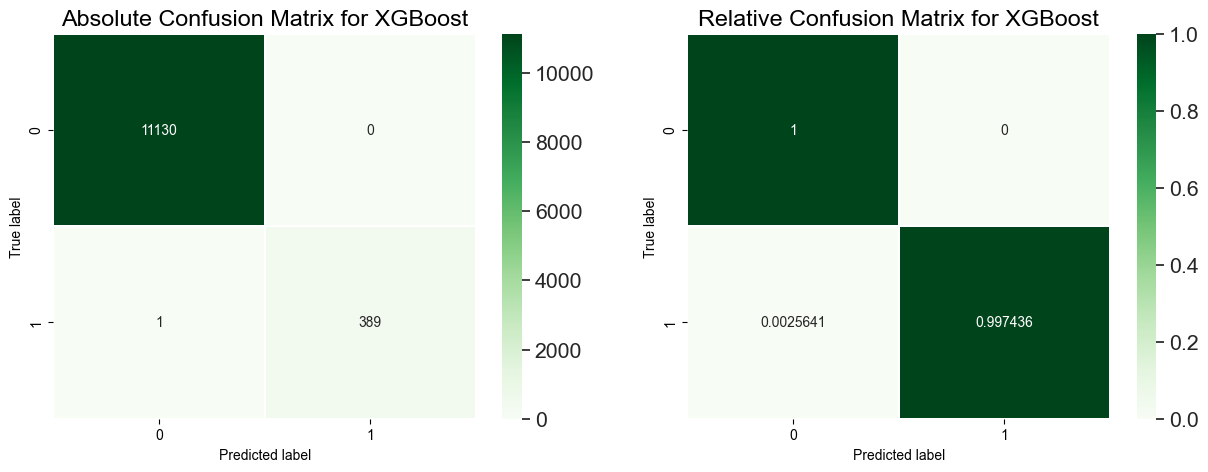

In [17]:
model = XGBoost_classification_tunned(best_hyperparams)

In [18]:

def while_XGBoost_classification_tunned(best_hyperparams, cycles=100):
    X=df_features[features]  # Features
    y=df_features['LABEL_code']  # Labels
    best_results = (0,"",None,None, None)
    i = 0
    print(f"\r{i}", end="")
    for i in range(cycles):
        print(f"\r{i}", end="", flush=True)
        tmp_f1 = 0
        tmp_str = ""
        #Split on train and test
        X_train_a, X_test_a, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y) # 70% training and 30% test
        for F, N in zip(
                [ features], # statistics_features, time_features, distribution_features, frequency_features, behavior_features, 
                [ "All"], # "Statistical-based", "Time-based", "Distribution-based",  "Frequency-based",  "Behavior-based", 
        ):
                X_train = X_train_a[F]
                X_test = X_test_a[F] 
                model = XGBClassifier(
                        n_estimators = int(best_hyperparams['n_estimators']), max_depth = int(best_hyperparams['max_depth']), 
                        gamma = best_hyperparams['gamma'],
                        reg_alpha = int(best_hyperparams['reg_alpha']),min_child_weight=int(best_hyperparams['min_child_weight']),
                        colsample_bytree=int(best_hyperparams['colsample_bytree']),
                        # subsample=int(best_hyperparams['subsample']),
                        # eta=best_hyperparams['eta'],
                )
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                accuracy = metrics.accuracy_score(y_test, y_pred)  * 100
                precision = precision_score(y_test, y_pred)  * 100
                recall = recall_score(y_test, y_pred)  * 100
                F1 = f1_score(y_test, y_pred)  * 100
                if N == "All":
                    tmp_str += "\multirow{-6}{*}{\\rotatebox{90}{\centering \\textbf{Our approach}}} & \cellcolor{Gray} \\textbf{All} & \\rowcolor{LigthGray}" 
                    tmp_str += "{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1)
                    tmp_str += "\n"
                    tmp_str += "\hline"
                    tmp_str += "\n"
                    tmp_f1 = F1
                elif N in ["Statistical-based", "Distribution-based", "Behavior-based"]:
                    tmp_str += "& \cellcolor{Gray} \\textbf{"
                    tmp_str += N
                    tmp_str += "} & " 
                    tmp_str += "{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1)
                    tmp_str += "\n"
                    tmp_str += "\cline{2-6}"
                    tmp_str += "\n"
                else:
                    tmp_str += "& \cellcolor{Gray} \\textbf{"
                    tmp_str += N
                    tmp_str += "} & \\rowcolor{LigthGray} " 
                    tmp_str += "{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1)
                    tmp_str += "\n"
                    tmp_str += "\cline{2-6}"
                    tmp_str += "\n"
        if best_results[0] < tmp_f1:
            matrix, percentage_matrix = get_confusion_matrix(y_test, y_pred)
            best_results = (tmp_f1, tmp_str, matrix, percentage_matrix, model)
    print("")
    print("")
    print("")
    print(best_results[0])
    print(best_results[1])
    plot_confusion_matrix(best_results[2], best_results[3], model="XGBoost")
    return best_results[4]

24


100.0
\multirow{-6}{*}{\rotatebox{90}{\centering \textbf{Our approach}}} & \cellcolor{Gray} \textbf{All} & \rowcolor{LigthGray}100.00 & 100.00 & 100.00 & 100.00 \\
\hline



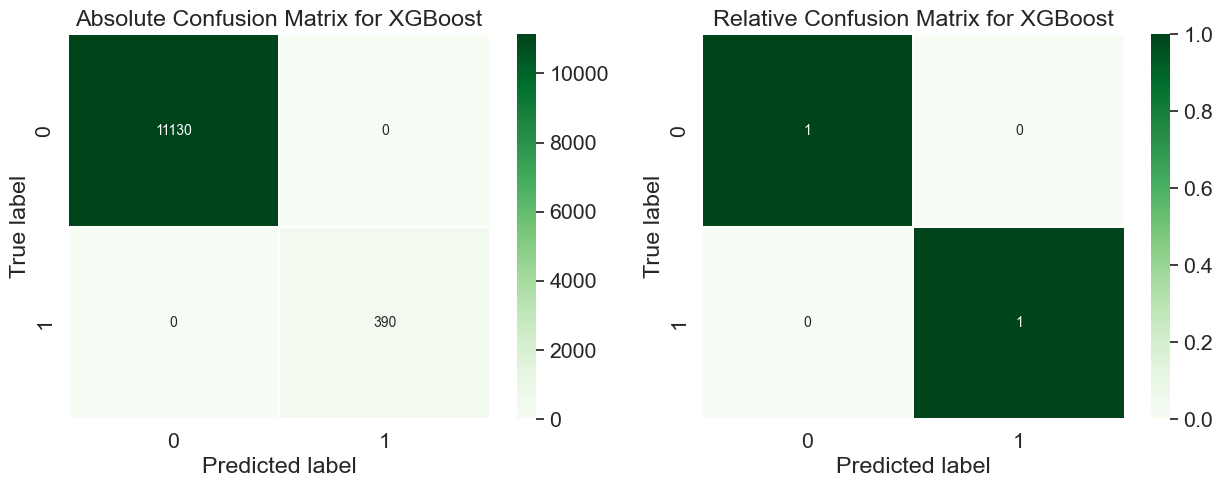

In [19]:
best_model = while_XGBoost_classification_tunned(best_hyperparams, cycles=25)

\multirow{-6}{*}{\rotatebox{90}{\centering \textbf{Our approach}}} & \cellcolor{Gray} \textbf{All} & \rowcolor{LigthGray}100.00 & 100.00 & 100.00 & 100.00 \\
\hline



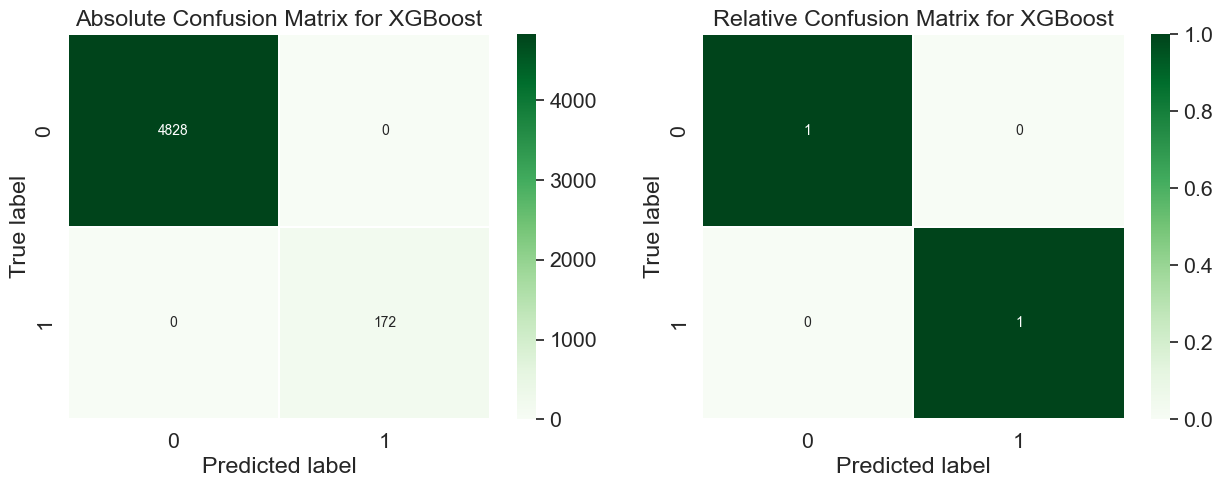

In [20]:
X_validation=df_validation[features]  # Features
y_validation=df_validation['LABEL_code']  # Labels
    

y_pred = best_model.predict(X_validation)
accuracy = metrics.accuracy_score(y_validation, y_pred)  * 100
precision = precision_score(y_validation, y_pred)  * 100
recall = recall_score(y_validation, y_pred)  * 100
F1 = f1_score(y_validation, y_pred)  * 100
                
tmp_str = ""
tmp_str += "\multirow{-6}{*}{\\rotatebox{90}{\centering \\textbf{Our approach}}} & \cellcolor{Gray} \\textbf{All} & \\rowcolor{LigthGray}" 
tmp_str += "{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1)
tmp_str += "\n"
tmp_str += "\hline"
tmp_str += "\n"
print(tmp_str)

matrix, percentage_matrix = get_confusion_matrix(y_validation, y_pred)
plot_confusion_matrix(matrix, percentage_matrix, model="XGBoost")

In [21]:
import csv

problem = "VPN-VNAT-binary"
with open("feature_reduction_results.csv", "a") as f:
    writer = csv.writer(f)
    writer.writerow([problem, "-", accuracy, precision, recall, F1, 0, 0, 0])

# Feature importance

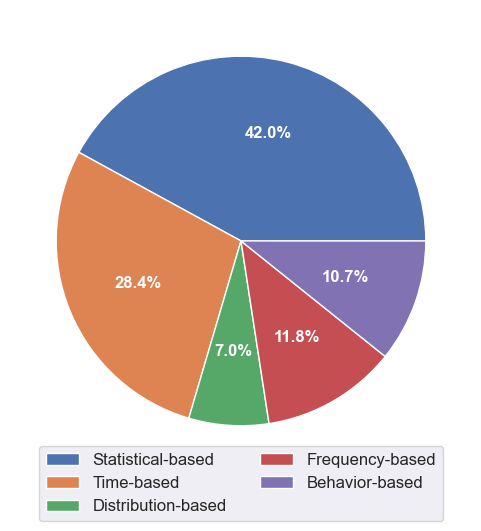

In [22]:
feat_importances = pd.Series(best_model.feature_importances_, index = X_validation.columns).sort_values(ascending = True)

f_sf = feat_importances[statistics_features].sum()
f_tf = feat_importances[time_features].sum()
f_df = feat_importances[distribution_features].sum()
f_ff = feat_importances[frequency_features].sum()
f_bf = feat_importances[behavior_features].sum()
# f_def = feat_importances[default_faetures].sum()

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
data = [f_sf, f_tf, f_df, f_ff, f_bf] #, f_def]
ingredients = ["Statistical-based", "Time-based", "Distribution-based",  "Frequency-based",  "Behavior-based"] # , "Default"]
def func(pct, allvals):
    return "{:.1f}%".format(pct)
wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))
ax.legend(wedges, ingredients,
          loc="center",
          bbox_to_anchor=(0.5, 0, 0, -0.05),
          prop={'size': 12},
          ncol=2)
plt.setp(autotexts, size=12, weight="bold")
plt.show()

In [23]:
data

[0.38116494, 0.2575011, 0.06332256, 0.107187636, 0.09746248]

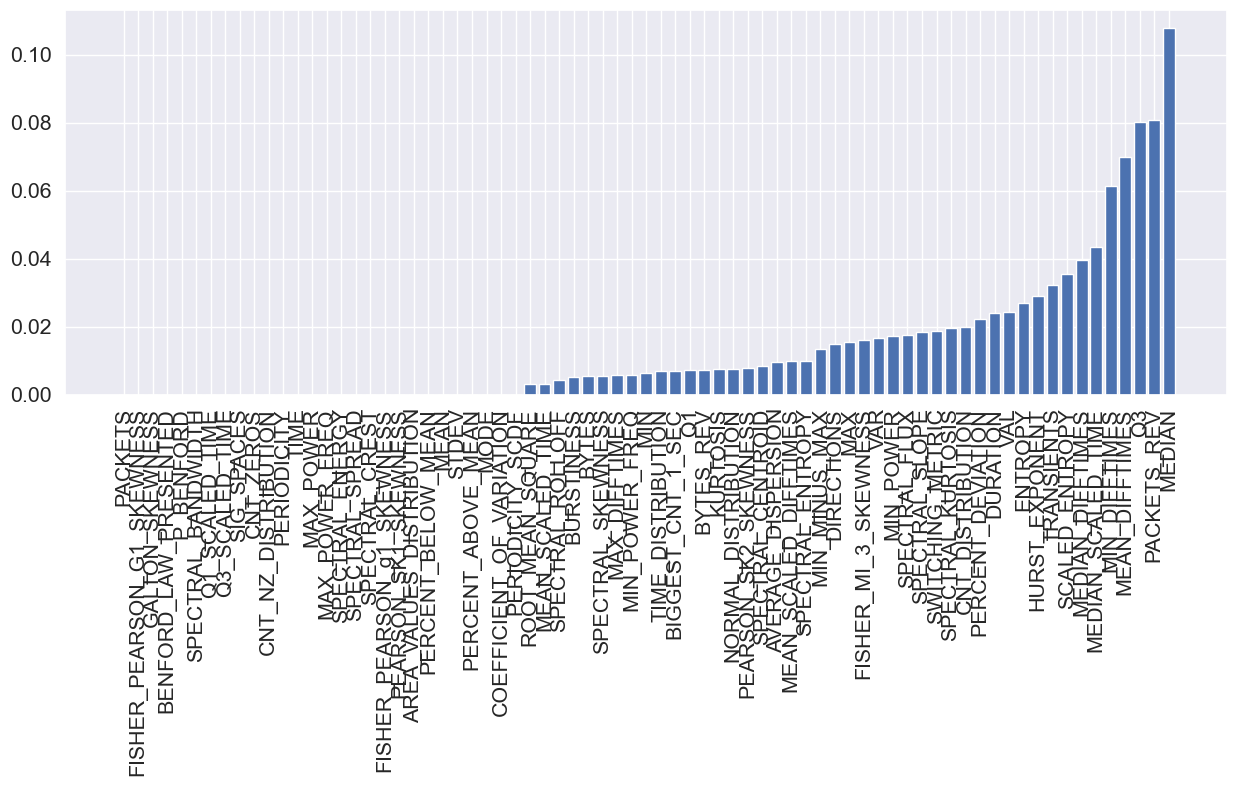

In [24]:
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(feat_importances.keys(), feat_importances.values)
plt.xticks(rotation = 90)
plt.show()

In [25]:
feat_importances

PACKETS                       0.000000
FISHER_PEARSON_G1_SKEWNESS    0.000000
GALTON_SKEWNESS               0.000000
BENFORD_LAW_PRESENTED         0.000000
P_BENFORD                     0.000000
                                ...   
MIN_DIFFTIMES                 0.061452
MEAN_DIFFTIMES                0.069991
Q3                            0.080065
PACKETS_REV                   0.080657
MEDIAN                        0.107831
Length: 73, dtype: float32

In [26]:
feat_importances.to_dict()

{'PACKETS': 0.0,
 'FISHER_PEARSON_G1_SKEWNESS': 0.0,
 'GALTON_SKEWNESS': 0.0,
 'BENFORD_LAW_PRESENTED': 0.0,
 'P_BENFORD': 0.0,
 'SPECTRAL_BANDWIDTH': 0.0,
 'Q1_SCALED_TIME': 0.0,
 'Q3_SCALED_TIME': 0.0,
 'SIG_SPACES': 0.0,
 'CNT_ZEROS': 0.0,
 'CNT_NZ_DISTRIBUTION': 0.0,
 'PERIODICITY': 0.0,
 'TIME': 0.0,
 'MAX_POWER': 0.0,
 'MAX_POWER_FREQ': 0.0,
 'SPECTRAL_ENERGY': 0.0,
 'SPECTRAL_SPREAD': 0.0,
 'SPECTRAL_CREST': 0.0,
 'FISHER_PEARSON_g1_SKEWNESS': 0.0,
 'PEARSON_SK1_SKEWNESS': 0.0,
 'AREA_VALUES_DISTRIBUTION': 0.0,
 'PERCENT_BELOW_MEAN': 0.0,
 'MEAN': 0.0,
 'STDEV': 0.0,
 'PERCENT_ABOVE_MEAN': 0.0,
 'MODE': 0.0,
 'COEFFICIENT_OF_VARIATION': 0.0,
 'PERIODICITY_SCDF': 0.0,
 'ROOT_MEAN_SQUARE': 0.0030605352949351072,
 'MEAN_SCALED_TIME': 0.003193481359630823,
 'SPECTRAL_ROLLOFF': 0.004449560772627592,
 'BURSTINESS': 0.005328008905053139,
 'BYTES': 0.005378311965614557,
 'SPECTRAL_SKEWNESS': 0.005471420474350452,
 'MAX_DIFFTIMES': 0.005807398818433285,
 'MIN_POWER_FREQ': 0.0058704009279

# FEATURE SELECTION

In [27]:
def perform_val(selected_features, best_hyperparams=None, cycles=25):
    if best_hyperparams is None:
        best_hyperparams = tunne_together_XGBoost_classification(df_features, selected_features, verbose=False)
    
    X=df_features[selected_features]  # Features
    y=df_features['LABEL_code']  # Labels

    best = 0
    best_model = None
    for i in range(0, cycles):    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y) # 70% training and 30% test   
        model = XGBClassifier(
            n_estimators = int(best_hyperparams['n_estimators']), max_depth = int(best_hyperparams['max_depth']), gamma = best_hyperparams['gamma'],
            reg_alpha = int(best_hyperparams['reg_alpha']),min_child_weight=int(best_hyperparams['min_child_weight']),
            colsample_bytree=int(best_hyperparams['colsample_bytree']),
        )
        model.fit(X_train, y_train)                
        y_pred = model.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, y_pred)  * 100
        precision = precision_score(y_test, y_pred)  * 100
        recall = recall_score(y_test, y_pred)  * 100
        F1 = f1_score(y_test, y_pred)  * 100
        if F1 > best:   
            best = F1
            best_model = model
            
    
    X_validation=df_validation[selected_features]  # Features
    y_validation=df_validation['LABEL_code']  # Labels

    y_pred = best_model.predict(X_validation)
    accuracy = metrics.accuracy_score(y_validation, y_pred)  * 100
    precision = precision_score(y_validation, y_pred)  * 100
    recall = recall_score(y_validation, y_pred)  * 100
    F1 = f1_score(y_validation, y_pred)  * 100
    
    return accuracy,precision,recall,F1

In [28]:
import FEATURE_REDUCTED as FR
REPORTS = []

report = perform_val(FR.botnet_best_features)
REPORTS.append(report)
report = perform_val(FR.doh_best_features)
REPORTS.append(report)
report = perform_val(FR.dos_best_features)
REPORTS.append(report)
report = perform_val(FR.dns_malware_features)
REPORTS.append(report)
report = perform_val(FR.tor_features)
REPORTS.append(report)
report = perform_val(FR.vpn_features)
REPORTS.append(report)
report = perform_val(FR.all_best_features)
REPORTS.append(report)
report = perform_val(FR.combo_features)
REPORTS.append(report)
report = perform_val(FR.combo_2_features)
REPORTS.append(report)
report = perform_val(FR.crypto_features)
REPORTS.append(report)

100%|██████████| 100/100 [00:32<00:00,  3.09trial/s, best loss: -0.9807938540332907]
The best hyperparameters are :  

{'colsample_bytree': 0.2769178918322269, 'gamma': 6.714666696185831, 'max_depth': 30.0, 'min_child_weight': 1.0, 'n_estimators': 140.0, 'reg_alpha': 1.0, 'reg_lambda': 0.19853369866202156}
100%|██████████| 100/100 [00:32<00:00,  3.10trial/s, best loss: -0.9935483870967742]
The best hyperparameters are :  

{'colsample_bytree': 0.2203988011108299, 'gamma': 3.265384416323076, 'max_depth': 20.0, 'min_child_weight': 0.0, 'n_estimators': 240.0, 'reg_alpha': 0.0, 'reg_lambda': 0.3013520483078699}
100%|██████████| 100/100 [00:27<00:00,  3.67trial/s, best loss: -0.9922680412371134]
The best hyperparameters are :  

{'colsample_bytree': 0.9346402796904334, 'gamma': 2.974412966661644, 'max_depth': 24.0, 'min_child_weight': 8.0, 'n_estimators': 200.0, 'reg_alpha': 0.0, 'reg_lambda': 0.48884181034394325}
100%|██████████| 100/100 [00:28<00:00,  3.56trial/s, best loss: -0.9896907216

In [29]:
import csv

problem = "VPN-VNAT-binary"
with open("feature_reduction_results.csv", "a") as f:
    writer = csv.writer(f)
    for report, f_set in zip(REPORTS, FR.FEATURE_SETS):
        writer.writerow([problem, f_set, report[0], report[1], report[2], report[3], 0, 0, 0])